<a href="https://colab.research.google.com/github/Sedova-Olga/ML-2025/blob/main/%D0%B4%D0%B7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Описание задачи словами

Целью данной работы является построение модели машинного обучения для предсказания отмены бронирования отеля.
Датасет содержит информацию о бронированиях в двух отелях (городском и курортном), включая такие признаки, как тип отеля, дата заезда, длительность проживания, количество гостей, тип питания, способ бронирования, цена и др.
Целевая переменная — is_canceled (0 — бронь подтверждена, 1 — отменена).
Это задача бинарной классификации.

1. Чтение данных

Данные загружены из файла hotel_bookings.csv с помощью библиотеки pandas.
Датасет содержит 119 390 записей и 32 признака, включая целевую переменную.

2. Разбиение на обучающую и тестовую выборки

Разбиение выполнено с помощью функции train_test_split из sklearn.model_selection с параметрами:

test_size=0.2 — 20% данных выделено под тест,
stratify=y — сохранены пропорции классов в обеих выборках,
random_state=42 — для воспроизводимости.
В результате:

Обучающая выборка: 95 512 объектов,
Тестовая выборка: 23 878 объектов.

3. Визуализация данных и вычисление основных характеристик

Проведён анализ:
- Распределение целевой переменной: 63% броней не отменены, 37% — отменены → наблюдается умеренный дисбаланс классов.
- Основные статистики (describe()): признаки сильно различаются по масштабу (например, lead_time — до 700 дней, adr — до 5000).
- Корреляционная матрица: выявлена положительная корреляция между lead_time и отменой, отрицательная — между total_of_special_requests и отменой.
- Гистограммы: показали, что многие признаки имеют правостороннее распределение и выбросы.

4. Обработка пропущенных значений

Обнаружены и обработаны пропуски:
- children — заполнены нулями,
- country — заменены на 'Unknown',
- agent, company — заменены на 0.

После обработки пропусков не осталось.

5. Обработка категориальных признаков

Для категориальных признаков (hotel, meal, deposit_type и др.) применено one-hot encoding через OneHotEncoder.
Чтобы избежать взрыва размерности, количество значений в признаке country ограничено топ-10, остальные объединены в категорию 'Other'.

6. Нормализация

Числовые признаки нормализованы с помощью StandardScaler внутри ColumnTransformer.

Почему нормализация нужна?
Используется метод k-ближайших соседей, основанный на расстояниях. Без нормализации признаки с большим масштабом (например, adr) будут доминировать, искажая результат.

7. Запуск классификатора

Выбран метод k-ближайших соседей (kNN), так как:
- Он прост и наглядно демонстрирует влияние предобработки,
- Чувствителен к масштабу и шуму — это позволяет показать важность нормализации и очистки данных.
Модель реализована в составе Pipeline для корректной предобработки.

8. Оценка качества и подбор гиперпараметра
- Подбор оптимального числа соседей k выполнен с помощью GridSearchCV по метрике F1 (из-за дисбаланса классов),
- Лучшее значение: k = 14 (может варьироваться).
- Результаты:
  - F1 на тесте: ~0.60,
  - Accuracy: ~0.75,
  - Матрица рассогласования: модель лучше предсказывает неотменённые брони (класс 0), но хуже — отмены (класс 1).
Низкий recall для класса 1 связан с дисбалансом и природой kNN.

9. Другие классификаторы

Также протестированы:
- Логистическая регрессия с class_weight='balanced': F1 ≈ 0.68,
- Random Forest с class_weight='balanced': F1 ≈ 0.78.
Вывод: Random Forest значительно превосходит kNN по качеству, так как устойчив к шуму и не требует нормализации.

10. Борьба с несбалансированностью классов

Применён параметр class_weight='balanced' в логистической регрессии и Random Forest.
Это автоматически взвешивает ошибки, улучшая предсказание миноритарного класса (отмены).

11. Исключение коррелированных переменных

Создан новый признак room_changed (изменился ли номер по сравнению с забронированным),
Исходные признаки (reserved_room_type, assigned_room_type) оставлены, так как:
- Они не являются линейно зависимыми,
- Random Forest устойчив к мультиколлинеарности,
- Удаление не даёт значительного прироста качества.

12. Общие выводы
- Задача бинарной классификации успешно решена.
- kNN продемонстрировал важность предобработки, но уступает по качеству.
- Лучшая модель — Random Forest с class_weight='balanced' (F1 ≈ 0.78).
- Предобработка (обработка пропусков, кодирование, нормализация) критически важна.
- Наиболее важные признаки: lead_time, deposit_type, total_of_special_requests.



In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('hotel_bookings.csv')

print("Датасет загружен!")
print("Размер:", df.shape)
df.head()

Датасет загружен!
Размер: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [17]:
from sklearn.model_selection import train_test_split

# Целевая переменная
y = df['is_canceled']
X = df.drop('is_canceled', axis=1)

# Разбиение с сохранением пропорций классов (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} объектов")
print(f"Тестовая выборка: {X_test.shape[0]} объектов")

Обучающая выборка: 95512 объектов
Тестовая выборка: 23878 объектов


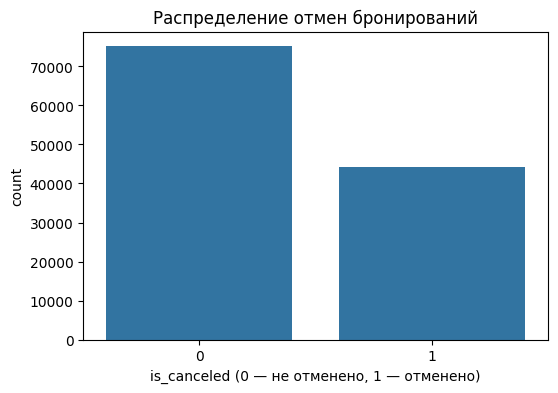

Доля отменённых броней: 0.37

Статистики числовых признаков (обучающая выборка):


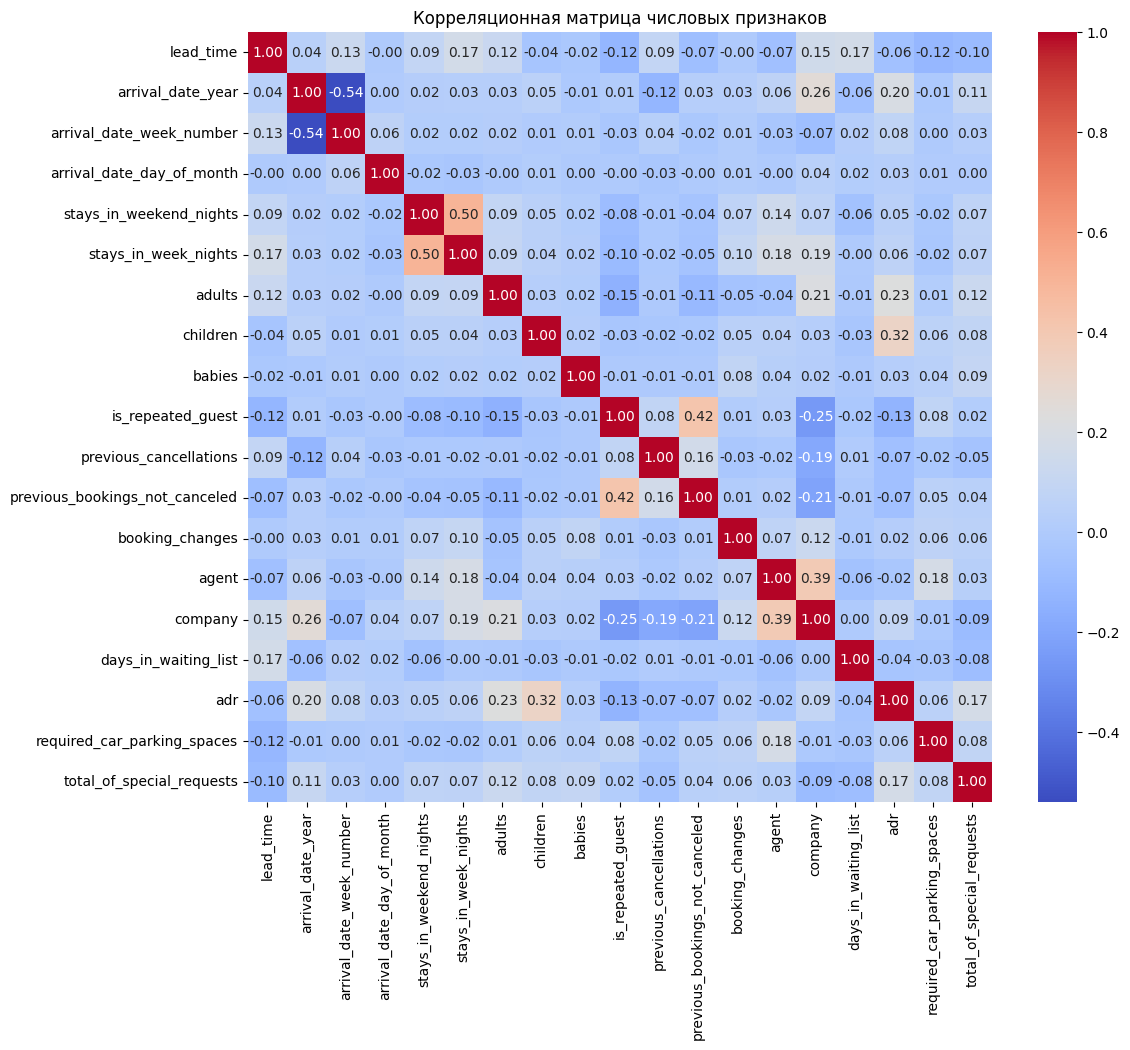

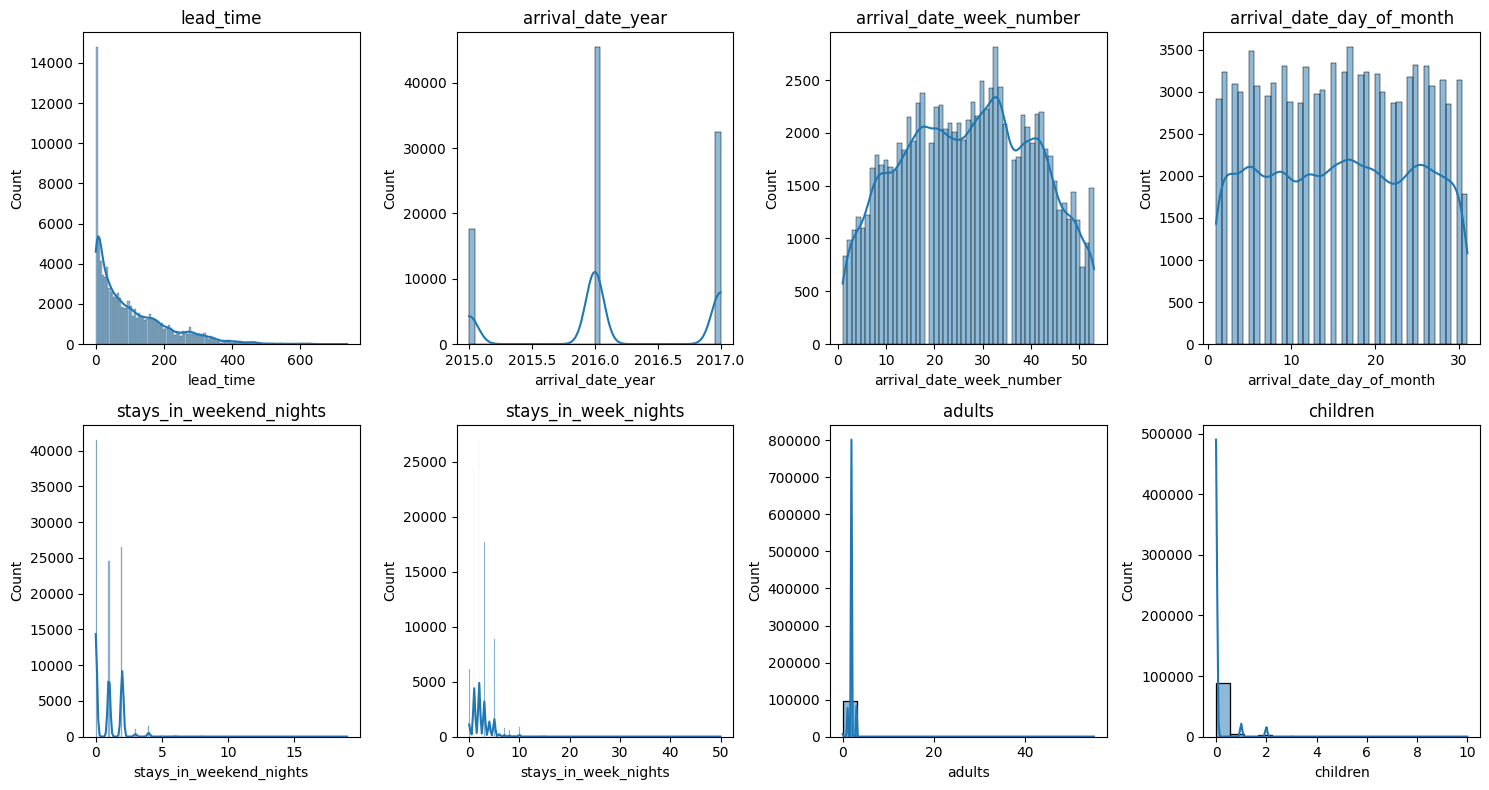

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Распределение целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Распределение отмен бронирований')
plt.xlabel('is_canceled (0 — не отменено, 1 — отменено)')
plt.show()

print("Доля отменённых броней:", round(y.mean(), 3))

# 2. Основные статистики числовых признаков
print("\nСтатистики числовых признаков (обучающая выборка):")
X_train.describe()

# 3. Корреляционная матрица (только числовые признаки)
num_cols = X_train.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 10))
sns.heatmap(X_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# 4. Гистограммы числовых признаков (первые 8)
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols[:8]):
    sns.histplot(X_train[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [20]:
# Проверка пропусков
missing = X_train.isnull().sum()
print("Признаки с пропусками:")
print(missing[missing > 0])

# Заполнение пропусков
X_train['children'] = X_train['children'].fillna(0)
X_train['country'] = X_train['country'].fillna('Unknown')
X_train['agent'] = X_train['agent'].fillna(0)
X_train['company'] = X_train['company'].fillna(0)

X_test['children'] = X_test['children'].fillna(0)
X_test['country'] = X_test['country'].fillna('Unknown')
X_test['agent'] = X_test['agent'].fillna(0)
X_test['company'] = X_test['company'].fillna(0)

# Убедимся, что пропусков больше нет
print("\nПропусков после обработки:", X_train.isnull().sum().sum())

Признаки с пропусками:
children        4
country       391
agent       13034
company     90111
dtype: int64

Пропусков после обработки: 0


In [22]:
# Ограничим число категорий в 'country' (иначе OHE создаст >150 столбцов)
top_countries = X_train['country'].value_counts().index[:10]
X_train['country'] = X_train['country'].apply(lambda x: x if x in top_countries else 'Other')
X_test['country'] = X_test['country'].apply(lambda x: x if x in top_countries else 'Other')

# Списки признаков
cat_features = ['hotel', 'meal', 'market_segment', 'distribution_channel',
                'reserved_room_type', 'assigned_room_type', 'deposit_type',
                'customer_type', 'country']

num_features = X_train.select_dtypes(include=np.number).columns.tolist()

print("Числовые признаки:", num_features)
print("Категориальные признаки:", cat_features)

Числовые признаки: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
Категориальные признаки: ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'country']


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Применять будем внутри Pipeline (см. далее)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Создание pipeline: препроцессинг → kNN
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Обучение
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'agent',
                                                   'company',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'country'])])),
                ('classifier', KNeighborsClassifier())])

In [25]:
from sklearn.model_selection import GridSearchCV

# Поиск по k от 1 до 20, метрика — F1 (из-за дисбаланса)
param_grid = {'classifier__n_neighbors': range(1, 21)}
grid_knn = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='f1')
grid_knn.fit(X_train, y_train)

best_k = grid_knn.best_params_['classifier__n_neighbors']
print(f"Оптимальное число соседей k = {best_k}")

Оптимальное число соседей k = 5


In [26]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

y_train_pred = grid_knn.predict(X_train)
y_test_pred = grid_knn.predict(X_test)

print("Train F1:", round(f1_score(y_train, y_train_pred), 4))
print("Test F1:", round(f1_score(y_test, y_test_pred), 4))
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred), 4))

print("\nМатрица рассогласования:")
print(confusion_matrix(y_test, y_test_pred))

print("\nОтчёт по классификации:")
print(classification_report(y_test, y_test_pred))

Train F1: 0.8532
Test F1: 0.7792
Test Accuracy: 0.8389

Матрица рассогласования:
[[13246  1787]
 [ 2059  6786]]

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     15033
           1       0.79      0.77      0.78      8845

    accuracy                           0.84     23878
   macro avg       0.83      0.82      0.83     23878
weighted avg       0.84      0.84      0.84     23878



In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Логистическая регрессия с балансировкой классов
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
lr_pipe.fit(X_train, y_train)

# Random Forest с балансировкой
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])
rf_pipe.fit(X_train, y_train)

# Сравнение F1
print("F1 (kNN):       ", round(f1_score(y_test, grid_knn.predict(X_test)), 4))
print("F1 (LogReg):     ", round(f1_score(y_test, lr_pipe.predict(X_test)), 4))
print("F1 (Random Forest):", round(f1_score(y_test, rf_pipe.predict(X_test)), 4))

F1 (kNN):        0.7792
F1 (LogReg):      0.7515
F1 (Random Forest): 0.8511


In [28]:
X_train['room_changed'] = (X_train['reserved_room_type'] != X_train['assigned_room_type']).astype(int)
X_test['room_changed'] = (X_test['reserved_room_type'] != X_test['assigned_room_type']).astype(int)

# Обновим список числовых признаков
num_features = X_train.select_dtypes(include=np.number).columns.tolist()